In [9]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import os
import logging
from helper import getModelDict
delphesDir = os.path.abspath("./DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

In [10]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

### Files to be compared

In [11]:
filesDict = {
                r'Signal' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events.root',
                # r'Signal (no matching)' : './pp2chi0chi0_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events.root',
                r'Signal (no smearing)' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events_nosmear.root',
}

modelDict = {}
for key,f in list(filesDict.items()):
    if not os.path.isfile(f):
        print(f'File {f} not found. Skipping.')
        filesDict.pop(key)
    else:
        modelDict[key] = getModelDict(f,verbose=False)

if len(set([tuple(d.items()) for d in modelDict.values()])) > 1:
    print('Several models being used!')
    mDict = None
else:
    mDict = list(modelDict.values())[0]


### Get kinematical variables for each file

In [12]:
L1metStr = r'$E_T^{\rm miss}$ (Hardware Trigger, N-1) (GeV)'
L1njStr = r'$n_{j}$ (Hardware Trigger, N)'
L1pTj1Str = r'Leading jet $E_{T}$ (Hardware Trigger, N) (GeV)'
L1dPhi = r'$\Delta \phi^{min} (MET,j)$ (Hardware Trigger)'
L1metPartonStr = r'$E_T^{\rm miss}$ (Parton Level, N-1) (GeV)'

HLTpTj1Str = r'Leading jet $E_{T}$ (Off-line, N) (GeV)'
HLTnjStr = r'$n_{j}$ (Off-line, N)'
HLTemfStr = r'EMF$_{\rm min}$ (Off-line, N)'


cols = ['label',L1metStr,L1njStr,L1pTj1Str,L1dPhi,L1metPartonStr,HLTnjStr,HLTpTj1Str,HLTemfStr]


dataList = []
for label,file in filesDict.items():   
    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    for ievt in range(nevts):
        tree.GetEntry(ievt)

        # Get parton level MET
        llps = list(tree.llpParticles)
        invisibles = [p for p in tree.llpDirectDaughters 
                      if abs(p.PID) == 4000022]
        invisibles = sorted(invisibles, key = lambda p: p.M1)
        pInvTot = np.zeros(3)
        for illp,llp in enumerate(llps):
            daughter = invisibles[illp]
            decayTime = daughter.T
            if decayTime < 10e-9: # if LLP decays on-time, add its daughter momentum
                pInv = np.array([daughter.Px,daughter.Py,
                                 daughter.Pz])
            else: # add the LLP momentum
                pInv = np.array([llp.Px,llp.Py,
                                llp.Pz])
            pInvTot += pInv
        
        metParton = np.linalg.norm(pInvTot[:2])
                
        metOnTime = tree.L1METOnTime.At(0)
        jetsDelayed = list(tree.L1JetDelayed)
        jetsDelayed = sorted(jetsDelayed, 
                         key = lambda j: j.PT, reverse=True)

        met = metOnTime.MET
        nj = len(jetsDelayed)
        if nj > 0:
            pTj1 = jetsDelayed[0].PT
            dphi_min = 10000.0
            for j in jetsDelayed[:6]:
                dphi = np.abs(j.Phi-metOnTime.Phi)
                if dphi > np.pi:
                    dphi = 2*np.pi-dphi
                dphi_min = min(dphi,dphi_min)
        else:
            pTj1 = 0.0
            dphi_min = 5.0


        jetsDelayedHLT = list(tree.HLTJetDelayed)
        jets = [j for j in jetsDelayedHLT[:] if abs(j.Eta) < 2.5]
        jets = [j for j in jets[:] if j.PT > 20.0]
        jets = sorted(jets, key = lambda j: j.PT, reverse=True)
        njHLT = len(jets)     
        pTHLT = 0.0
        emf_min = -1.0   
        if njHLT > 0:
            pTHLT = jets[0].PT
            jet_cells = []        
            for j in jets:
                closest_cell = None
                dRmin = 100.0
                for tower_cell in tree.HLTTowerDelayed:
                    dphi = np.abs(j.Phi-tower_cell.Phi)
                    deta = j.Eta-tower_cell.Eta
                    if dphi > np.pi:
                        dphi = 2*np.pi - dphi
                    dR = np.sqrt(deta**2 + dphi**2)
                    if dR < dRmin:
                        dRmin = dR
                        closest_cell = tower_cell
                
                jet_cells.append(closest_cell)
            # Compute minimum EMF:
            emf_min = min([cell.Eem/(cell.Eem + cell.Ehad) for cell in jet_cells])        


        dataList.append([label,met,nj,pTj1,dphi_min,metParton,njHLT,pTHLT,emf_min])
    f.Close()
df = pd.DataFrame(columns=cols,data=dataList)
        

In [13]:
for label in df['label'].unique():
    print(f'{label} has {len(df[df['label'] == label])} events')

Signal has 38862 events
Signal (no smearing) has 38862 events


### Add Tobias curves

In [14]:
tobiasCurves = {L1metStr : './B2TF-Tobias/results/l1_met_new.csv',
                L1njStr : './B2TF-Tobias/results/l1_nj_new.csv',
                L1pTj1Str : './B2TF-Tobias/results/l1_et_new.csv',
                L1dPhi : './B2TF-Tobias/results/l1_del_phi_new.csv',
                L1metPartonStr : './B2TF-Tobias/results/l1_met_new.csv',

                HLTnjStr : './B2TF-Tobias/results/offline_nj.csv',
                HLTpTj1Str : './B2TF-Tobias/results/offline_pt.csv',
                }

## Plot Distributions

In [15]:
plot_variables = [c for c in df.columns if c not in ['label', L1metPartonStr]]

colors = plt.colormaps['Paired'].colors[1::2]

binsDict = {L1metStr : np.arange(0.,300.,20.), 
            L1njStr : np.arange(-0.5,5.,1.),
            L1pTj1Str : np.arange(0.,100.,5.),
            L1dPhi : np.linspace(0.0,5.0,20),
            L1metPartonStr : np.arange(0.,300.,20.), 
            HLTemfStr : np.array([-1.5,-0.5,0.0,0.01,0.02,0.03,0.04,
                                    0.05,0.06,0.07,0.08,0.09,0.1,1.0])
            }

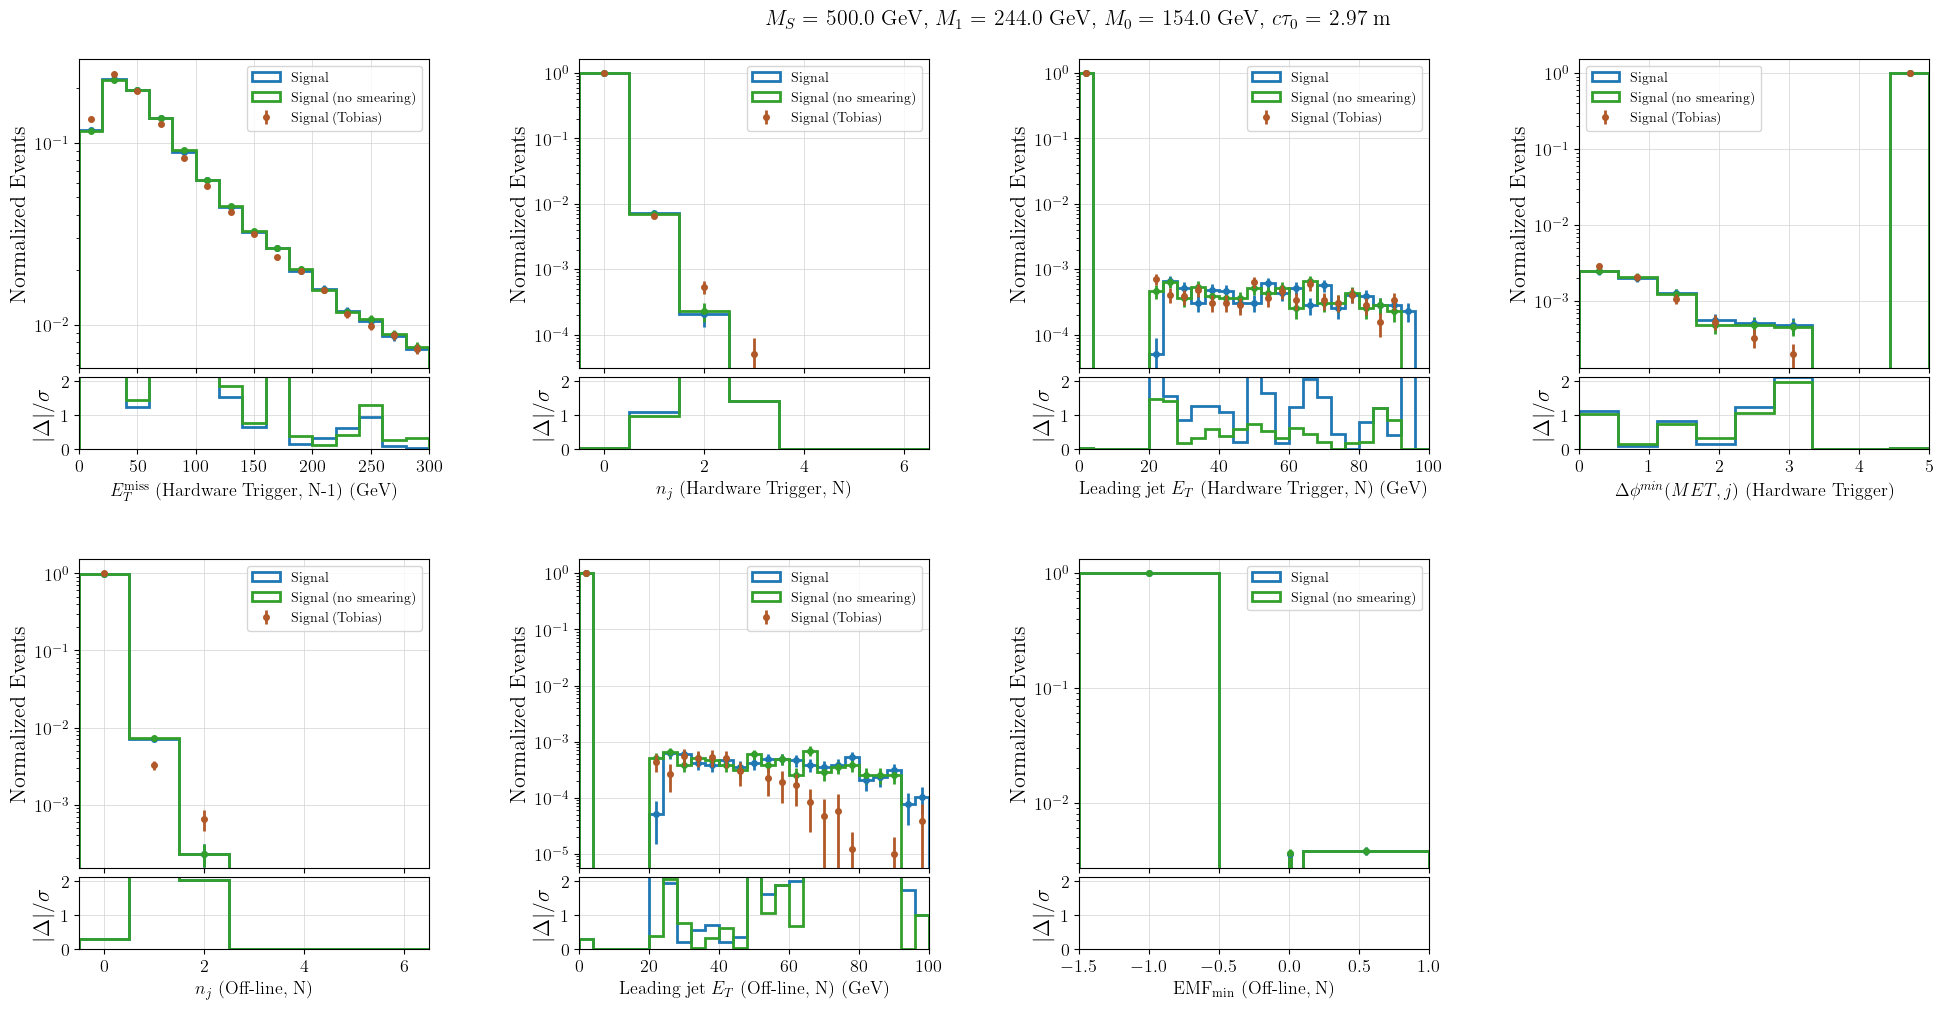

In [16]:
nrows = 2
ncols = int(np.ceil(len(plot_variables)/nrows))
# ncols = 4

# Create a figure for the nrows x ncols grid of plots
# Increased figsize to accommodate subplots
w,h = 5*ncols,5*nrows
fig = plt.figure(figsize=(w,h))

# Adjust overall subplot parameters
fig.subplots_adjust(hspace=0.4, wspace=0.3)

irow = 0
icol = 0
for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    if var in binsDict:
        bins = binsDict[var]
    else:
        bins = np.linspace(v_min,v_max,25)
    # print(var,bins)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ymax = 0.0

    # Create a GridSpec for the current subplot cell.
    # This divides the current subplot space into 2 rows and 1 column,
    # with the top row 3 times taller than the bottom (for histogram vs ratio).
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.7                                                  ])
    # Place the gridspec within the overall figure grid using its position
    # For a nrows x ncols grid, (row, col) translates to (i // ncols, i % ncols) 0.7
    toppadding = 0.07 # space for title
    wpadding = 0.1 #width space between plots
    hpadding = 0.15 #height space between plots
    wspace = 1.0-wpadding*(ncols-1) # total width available for plots
    hspace = 1.0-toppadding-hpadding*(nrows-1) # total height available for plots
    gs.update(left=icol*(1.0/ncols),
                right=(icol)*(1.0/ncols) + wspace/ncols,
                top=1.0-toppadding - (irow)*(1.0/nrows),
                bottom=1.0-toppadding - (irow)*(1.0/nrows) -hspace/nrows,
                hspace=0.05) # No horizontal space between histogram and ratio within a cell

    icol += 1
    if icol == ncols:
        icol = 0
        irow += 1

    # Add the GridSpec to the main figure's grid
    # The `add_subplot` method takes GridSpec as an argument for placement
    ax_ratio = fig.add_subplot(gs[1, 0]) # Bottom part for ratio, sharing x-axis with ax_hist
    ax_hist = fig.add_subplot(gs[0, 0]) # Top part for histograms
    

 
    # Add Tobias curve if found
    y0 = None
    if var in tobiasCurves:
        tobiasData = np.genfromtxt(tobiasCurves[var],delimiter=',',names=True)
        ax_hist.errorbar(tobiasData['bin_center'],
                    tobiasData['normalized_count'],
                    tobiasData['error'],
                    linewidth=2,                    
                    fmt="o",
                    color=colors[-1],
                    zorder=10,
                    label='Signal (Tobias)'
                    )
        y0 = tobiasData['normalized_count']
        y0Err = tobiasData['error']
        bin_centers = tobiasData['bin_center']
        bins = list(tobiasData['bin_left_edge'])
        bins.append(tobiasData['bin_right_edge'][-1])
    else:
        v_max, v_min = df[var].max(),df[var].min()
        if var in binsDict:
            bins = binsDict[var]
        else:
            bins = np.linspace(v_min,v_max,25)
        # print(var,bins)
        bin_centers = 0.5*(bins[1:] + bins[:-1])

    for j,label in enumerate(df['label'].unique()):
        if 'Signal' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        color = colors[j]
        data = df[df['label'] == label]
        # print('b2=',bins)
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        # print('bc=',bin_centers)
        _,_,p = ax_hist.hist(bin_centers,weights=y,bins=bins,histtype='step',
                linewidth=2,linestyle=ls,label=label,color=color)
        ax_hist.errorbar(bin_centers,y,yerr = yerr,
                        # marker = '.',
                        color=color,
                        # color=p[-1].get_facecolor(),
                        # drawstyle = 'steps-mid',label=label,
                        linewidth=2,
                        # linestyle=ls,
                        fmt="o")
        
    
        # Plot ratios
        # r_y = np.divide(y,y0)
        # r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        # ax_ratio.errorbar(bin_centers,r_y,yerr = r_error,marker = '.',drawstyle = 'steps-mid',
        #             label=label,linewidth=2,linestyle=ls,color=color)
        # Plot diff
        if y0 is not None:
            dy = y-y0
            dy_error = np.sqrt(yerr**2 + y0Err**2)
            ddy = np.abs(np.divide(dy, dy_error, out=np.zeros_like(dy_error), where= dy_error != 0))
            # ddy = np.array([dy[i]/dyerr for i,dyerr in enumerate(dynp.where(dy_error > 0., dy/dy_error,0.0)
            ax_ratio.hist(bin_centers,weights=ddy,bins=bins,histtype='step',
                            linewidth=2,linestyle=ls,label=label,color=color)
    

    
        
    
    ax_hist.set_ylabel('Normalized Events')
    ax_hist.set_xticklabels([])
    ax_hist.set_yscale('log')
    ax_hist.set_xlim(min(bins),max(bins))
    if i >= 0:
        ax_hist.legend()

    ax_ratio.set_xlabel(var,fontsize=13)
    ax_ratio.set_ylabel(r'$|\Delta|/\sigma$')
    ax_ratio.set_yticks([0.0,1.0,2.0])
    ax_ratio.set_ylim(0.0,2.1)
    ax_ratio.set_xlim(min(bins),max(bins))
    

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV, $c \tau_0$ = %1.2f m" %(mDict['mS'],mDict['m1'],mDict['m0'],c*mDict['tau']))

# Optimize layout to prevent labels/titles from overlapping
# plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust rect to make space for suptitle
plt.show()